# Agent

In [1]:
from environments.pika_env import PikaEnv
from environments.helper import open_game

In [2]:
class Config:
    def __init__(self):
        # environment
        self.base_address = 0x00002298
        self.image_size = [80, 80]
        self.interval_time = 0.2
        
        # model
        self.hidden_layer_size = 200
        self.learning_rate = 0.0005
        self.batch_size_episodes = 10
        self.load_checkpoint = "store_true"
        self.discount_factor = 0.99
        self.render = "store_true"

In [3]:
config = Config()

In [4]:
env = PikaEnv(config)

Found window : 0x000d0406: '뫮먰귃궔궭귙?갏?拒걍艱微뺂( 긹??붎 )'


In [5]:
env.action.window_name

'뫮먰귃궔궭귙?갏?拒걍艱微뺂( 긹??붎 )'

In [6]:
env.reset_game()

In [8]:
env.state.get_score()

(1, 0)

In [12]:
obervation, _, _, _ = env.step(4)

In [13]:
from PIL import Image

In [14]:
import numpy as np

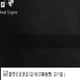

In [16]:
y = Image.fromarray(np.array(obervation[3, :]))
y = y.convert("RGB")
y

In [34]:
y = y.convert("RGB")

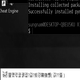

In [35]:
y

In [9]:
import argparse
import pickle
import numpy as np
import gym

from policy_network import Network

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [24]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

In [25]:
def discount_rewards(rewards, discount_factor):
    discounted_rewards = np.zeros_like(rewards)
    for t in range(len(rewards)):
        discounted_reward_sum = 0
        discount = 1
        for k in range(t, len(rewards)):
            discounted_reward_sum += rewards[k] * discount
            discount *= discount_factor
            if rewards[k] != 0:
                # Don't count rewards from subsequent rounds
                break
        discounted_rewards[t] = discounted_reward_sum
    return discounted_rewards

In [26]:
network = Network(
    config.hidden_layer_size, 
    config.learning_rate, 
    checkpoints_dir='checkpoints')